In [413]:
# import tools for analyzing timeseries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [330]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [470]:
dataframe=pd.read_excel('/content/drive/MyDrive/AirPassengers.xls',index_col=0)
spread=dataframe['Passangers']
spread.index = pd.to_datetime(spread.index)
spread.index.freq = 'MS'

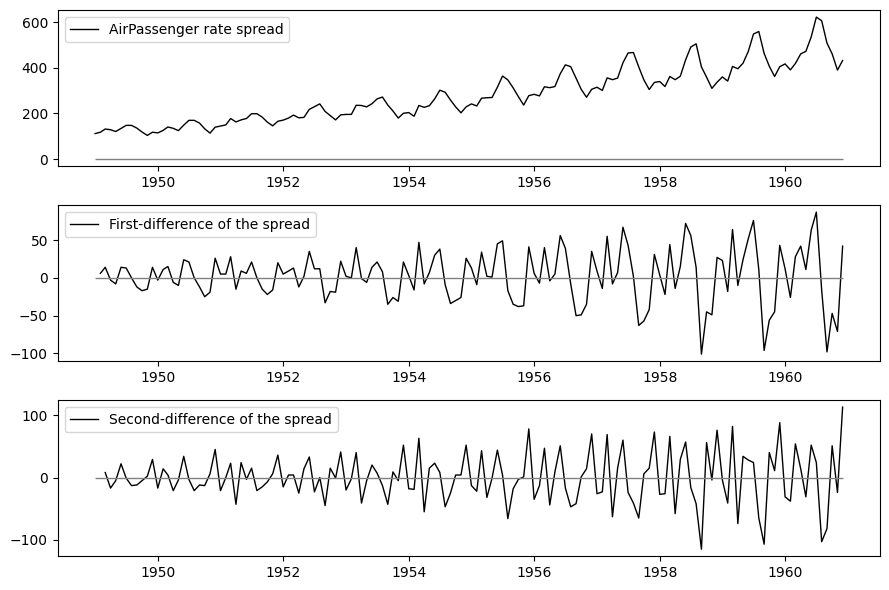

In [471]:
f, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 2*3))


axes[0].plot(spread,color='black',linewidth=1,label='AirPassenger rate spread')
axes[0].hlines(xmin=spread.index[0],xmax=spread.index[-1],y=0,color='gray',linewidth=1)
axes[0].legend()

axes[1].plot(spread.diff(),color='black',linewidth=1,label='First-difference of the spread')
axes[1].hlines(xmin=spread.index[0],xmax=spread.index[-1],y=0,color='gray',linewidth=1)
axes[1].legend()

axes[2].plot(spread.diff().diff(), color='black', linewidth=1, label='Second-difference of the spread')
axes[2].hlines(y=0, xmin=spread.index[0], xmax=spread.index[-1], color='gray', linewidth=1)
axes[2].legend()

plt.tight_layout()
plt.show()

In [472]:
def adf_test(dataframe):
  result = adfuller(dataframe)
  print(f'Statistics: {result[0]}')
  print(f'p-value: {result[1]}')
  print(f'Critical values: {result[4]}')

adf_test(spread)
print('---'*40)
adf_test(spread.diff().dropna())
print('---'*40)
adf_test(spread.diff().diff().dropna())

Statistics: 0.8153688792060498
p-value: 0.991880243437641
Critical values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
------------------------------------------------------------------------------------------------------------------------
Statistics: -2.8292668241700047
p-value: 0.05421329028382478
Critical values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
------------------------------------------------------------------------------------------------------------------------
Statistics: -16.384231542468513
p-value: 2.7328918500142026e-29
Critical values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


In [473]:
def kpss_test(dataframe):
  result = kpss(dataframe)
  print(f'Statistics: {result[0]}')
  print(f'bounded p-value: {result[1]}')
  print(f'Critical values: {result[3]}')

kpss_test(spread)
print('---'*40)
kpss_test(spread.diff().dropna())
print('---'*40)
adf_test(spread.diff().diff().dropna())

Statistics: 1.6513122354165206
bounded p-value: 0.01
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
------------------------------------------------------------------------------------------------------------------------
Statistics: 0.023897614400183967
bounded p-value: 0.1
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
------------------------------------------------------------------------------------------------------------------------
Statistics: -16.384231542468513
p-value: 2.7328918500142026e-29
Critical values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


<ipython-input-473-c59783a4a6e0>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(dataframe)
<ipython-input-473-c59783a4a6e0>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(dataframe)


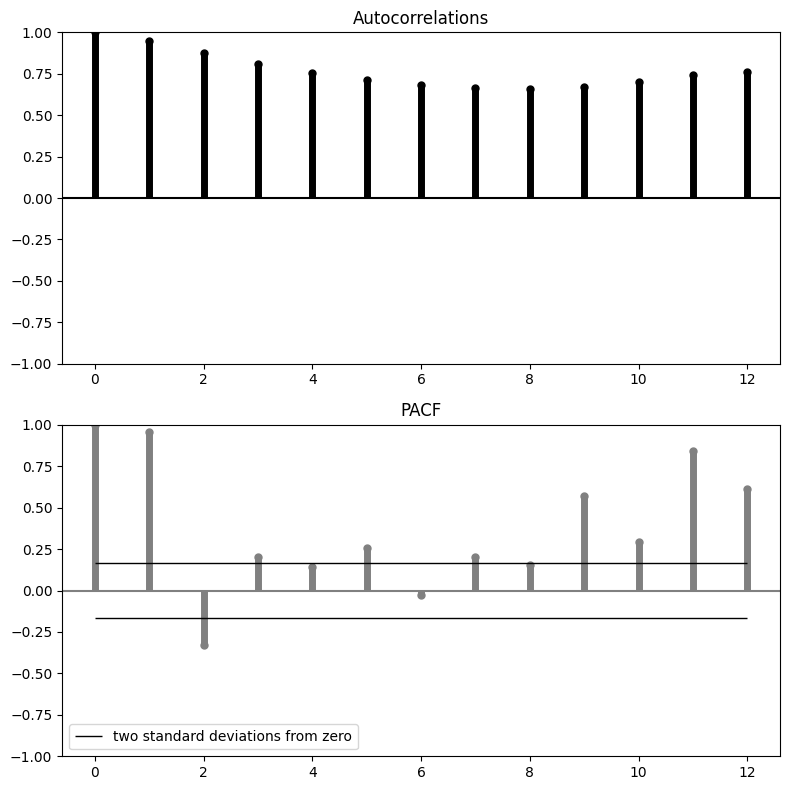

In [474]:
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 2*4))
plot_acf(spread, lags=12, ax=axes[0], title='Autocorrelations', color='black',vlines_kwargs={'colors':'black','linewidth':5}, alpha=None)
plot_pacf(spread, lags=12, ax=axes[1], method='ols', title='PACF', color='gray',vlines_kwargs={'colors':'gray','linewidth':5}, alpha=None)
axes[1].hlines(xmin=0,xmax=12,y=2*np.sqrt(1/len(spread)),label='two standard deviations from zero',color='black',linewidth=1)
axes[1].hlines(xmin=0,xmax=12,y=-2*np.sqrt(1/len(spread)),color='black',linewidth=1)
axes[1].legend()
plt.tight_layout()
plt.show()

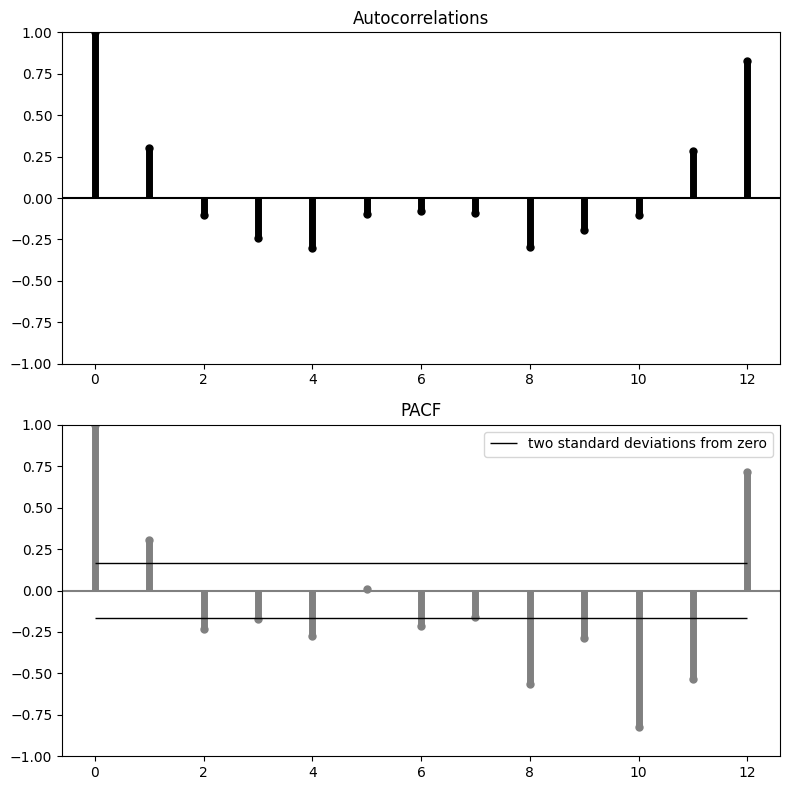

In [475]:
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 2*4))
plot_acf(spread.diff().dropna(), lags=12, ax=axes[0], title='Autocorrelations', color='black',vlines_kwargs={'colors':'black','linewidth':5}, alpha=None)
plot_pacf(spread.diff().dropna(), lags=12, ax=axes[1], method='ols', title='PACF', color='gray',vlines_kwargs={'colors':'gray','linewidth':5}, alpha=None)
axes[1].hlines(xmin=0,xmax=12,y=2*np.sqrt(1/len(spread)),label='two standard deviations from zero',color='black',linewidth=1)
axes[1].hlines(xmin=0,xmax=12,y=-2*np.sqrt(1/len(spread)),color='black',linewidth=1)
axes[1].legend()
plt.tight_layout()
plt.show()

In [476]:
# Define a function to get the maximum value(s) from an element in the set
def get_max_value(element):
    if isinstance(element, int) or isinstance(element, float):
        return element
    else:
        return max(element)

In [477]:
lag_list = [(2,1,0), (1,1,0), (1,1,1), (1, 1, 2), (1, 1, 3), (2,1,1), (2, 1, 2), (2, 1,3)]
# We will estimate 8 different models.

summary_table = dict()

idx=0
num_of_obs = len(spread[7:])

for lag in lag_list:
    # SSE i.e SSR, AIC, SBC, Ljung–Box Q-statistics of the residual autocorrelations for lag:={4, 8, 12}.
    temp_perf_dict = {key: key for key in ['SSE','AIC','SBC','Q(4)','Q(8)','Q(12)']}

    # Get the maximum value(s) from each element in the set
    max_values = [get_max_value(elem) for elem in lag]
    max_element = max(max_values)
    # We use spread[8-max_element:] to estimate each equation over the 1961Q4-2012Q4.
    res = ARIMA(endog = spread[8-max_element:], order=lag).fit(method='innovations_mle') # Use Durbin–Levinson algorithm. You can also use other estimation method.
    temp_perf_dict['SSE'] = round(res.sse,2)

    # Note that since we assume the model errors are IID according to a normal distribution, the BIC and AIC formula is bit different from a general form.
    temp_perf_dict['AIC'] = round(num_of_obs*np.log(res.sse) + 2*len(res.params),2)
    temp_perf_dict['SBC'] = round(num_of_obs*np.log(res.sse) + len(res.params)*np.log(num_of_obs),2)

    # Ljung-box Q-statistics for lag 4,8,12
    q_statistics = res.test_serial_correlation(method='ljungbox',lags=12)[0]

    temp_perf_dict['Q(4)'] = {'q_stats' : round(q_statistics[0][3],2), 'p_val': round(q_statistics[1][3],2)}
    temp_perf_dict['Q(8)'] = {'q_stats' : round(q_statistics[0][7],2), 'p_val': round(q_statistics[1][7],2)}
    temp_perf_dict['Q(12)'] = {'q_stats' : round(q_statistics[0][11],2), 'p_val': round(q_statistics[1][11],2)}

    for param_name, param in zip(res.params.index, res.params):
        temp_perf_dict[param_name] = {'coef':round(param,2), 't_stats':round(res.tvalues[param_name],2)}

    hashable_order = tuple([tuple(order) if isinstance(order,list) == True else order for order in res.specification['order']]) # make res.specification['order'] hashable.
    summary_table[hashable_order] = temp_perf_dict



<ipython-input-477-f3ab9aa36b4b>:17: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  res = ARIMA(endog = spread[8-max_element:], order=lag).fit(method='innovations_mle') # Use Durbin–Levinson algorithm. You can also use other estimation method.
<ipython-input-477-f3ab9aa36b4b>:17: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  res = ARIMA(endog = spread[8-max_element:], order=lag).fit(method='innovations_mle') # Use Durbin–Levinson algorithm. You can also use other estimation method.
<ipython-input-477-f3ab9aa36b4b>:17: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  res = ARIMA(endog = spread[8-max_element:], order=lag).fit(method='innovations_mle') # Use Durbin–Levinson algorithm. You can also use ot

In [478]:
table_2_4 = pd.DataFrame()
for key, value in summary_table.items():
    temp_series = pd.Series(value, name=key)
    table_2_4 = pd.concat([table_2_4,temp_series],axis=1)

In [479]:
table_2_4.loc[['ar.L1','ar.L2','ma.L1','ma.L2','ma.L3','SSE','AIC','SBC','Q(4)','Q(8)','Q(12)'],:] # For ordering the row of the table.

,"(2, 1, 0)","(1, 1, 0)","(1, 1, 1)","(1, 1, 2)","(1, 1, 3)","(2, 1, 1)","(2, 1, 2)","(2, 1, 3)"
ar.L1,"{'coef': 0.38, 't_stats': 4.18}","{'coef': 0.31, 't_stats': 3.68}","{'coef': -0.48, 't_stats': -3.74}","{'coef': 0.58, 't_stats': 5.74}","{'coef': 1.0, 't_stats': 136.15}","{'coef': 1.09, 't_stats': 12.71}","{'coef': 0.98, 't_stats': 49.17}","{'coef': -0.1, 't_stats': -0.26}"
ar.L2,"{'coef': -0.23, 't_stats': -3.34}",NaN,NaN,NaN,NaN,"{'coef': -0.49, 't_stats': -4.84}","{'coef': -0.98, 't_stats': -53.33}","{'coef': 0.44, 't_stats': 2.91}"
ma.L1,NaN,NaN,"{'coef': 0.87, 't_stats': 10.84}","{'coef': -0.32, 't_stats': -3.12}","{'coef': -1.1, 't_stats': -0.56}","{'coef': -0.84, 't_stats': -11.06}","{'coef': -0.85, 't_stats': -0.44}","{'coef': 0.38, 't_stats': 0.95}"
ma.L2,NaN,NaN,NaN,"{'coef': -0.51, 't_stats': -7.06}","{'coef': -0.79, 't_stats': -3.44}",NaN,"{'coef': 1.0, 't_stats': 0.22}","{'coef': -0.8, 't_stats': -8.47}"
ma.L3,NaN,NaN,NaN,NaN,"{'coef': 0.89, 't_stats': 0.51}",NaN,NaN,"{'coef': -0.29, 't_stats': -1.11}"
SSE,161219.47,168447.42,158910.81,148682.5,150594.2,142252.98,128015.07,141256.03
AIC,1648.7,1652.71,1646.73,1639.61,1643.36,1633.55,1621.11,1636.59
SBC,1657.46,1658.55,1655.49,1651.29,1657.96,1645.23,1635.71,1654.11
Q(4),"{'q_stats': 13.49, 'p_val': 0.01}","{'q_stats': 16.46, 'p_val': 0.0}","{'q_stats': 16.3, 'p_val': 0.0}","{'q_stats': 14.5, 'p_val': 0.01}","{'q_stats': 36.55, 'p_val': 0.0}","{'q_stats': 9.58, 'p_val': 0.05}","{'q_stats': 5.36, 'p_val': 0.25}","{'q_stats': 13.43, 'p_val': 0.01}"
Q(8),"{'q_stats': 30.87, 'p_val': 0.0}","{'q_stats': 26.64, 'p_val': 0.0}","{'q_stats': 27.49, 'p_val': 0.0}","{'q_stats': 34.35, 'p_val': 0.0}","{'q_stats': 81.32, 'p_val': 0.0}","{'q_stats': 21.61, 'p_val': 0.01}","{'q_stats': 52.53, 'p_val': 0.0}","{'q_stats': 27.05, 'p_val': 0.0}"


In [480]:
# out-of-sample prediction with expanding rolling window.

checker = spread.index <= '1959-01-01'

train_set = spread[checker]
test_set = spread[~checker]


n_train = len(train_set)
n_test = len(test_set)

f1, f1_error = [], []
f2, f2_error = [], []
ground_truth = []
for i in range(n_test):
    crt_time = i + n_train
    x_train = spread[:crt_time]

    # iterate over the time series data, fitting the model on each expanding window of data
    model_1 = ARIMA(endog = x_train, order=(1,1,2)).fit(method='innovations_mle') # model 1
    model_2 = ARIMA(endog = x_train, order=(2,1,1)).fit(method='innovations_mle') # model 2

    # one-step-ahead forecasts
    forecast_1 = model_1.forecast(steps=1)
    forecast_2 = model_2.forecast(steps=1)

    # true one-step-ahead value
    y = spread[crt_time]

    ground_truth.append(y)

    f1.append(forecast_1[0])
    f1_error.append(y-forecast_1[0])

    f2.append(forecast_2[0])
    f2_error.append(y-forecast_2[0])

<ipython-input-480-11c531f147fc>:20: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  model_1 = ARIMA(endog = x_train, order=(1,1,2)).fit(method='innovations_mle') # model 1
<ipython-input-480-11c531f147fc>:21: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  model_2 = ARIMA(endog = x_train, order=(2,1,1)).fit(method='innovations_mle') # model 2
<ipython-input-480-11c531f147fc>:20: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  model_1 = ARIMA(endog = x_train, order=(1,1,2)).fit(method='innovations_mle') # model 1
<ipython-input-480-11c531f147fc>:21: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  model_2 = AR

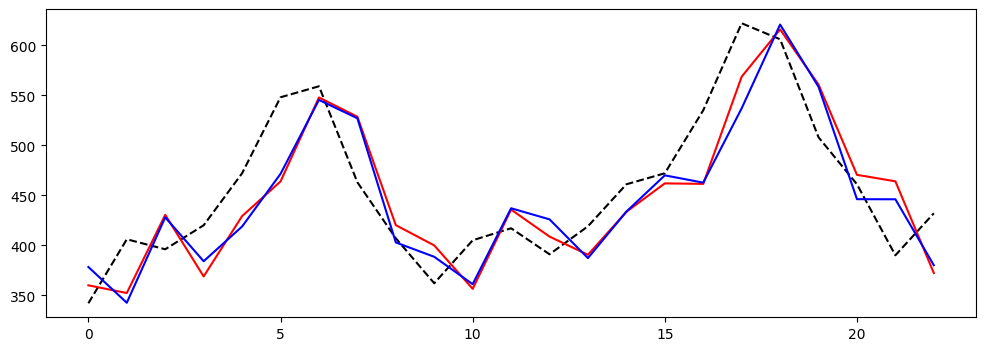

In [481]:
plt.figure(figsize=(12,4))

plt.plot(ground_truth, label='ground truth', color='k', linestyle='--')
plt.plot(f1, label='f1 predicted', color='r')
plt.plot(f2, label='f2 predicted', color='b')


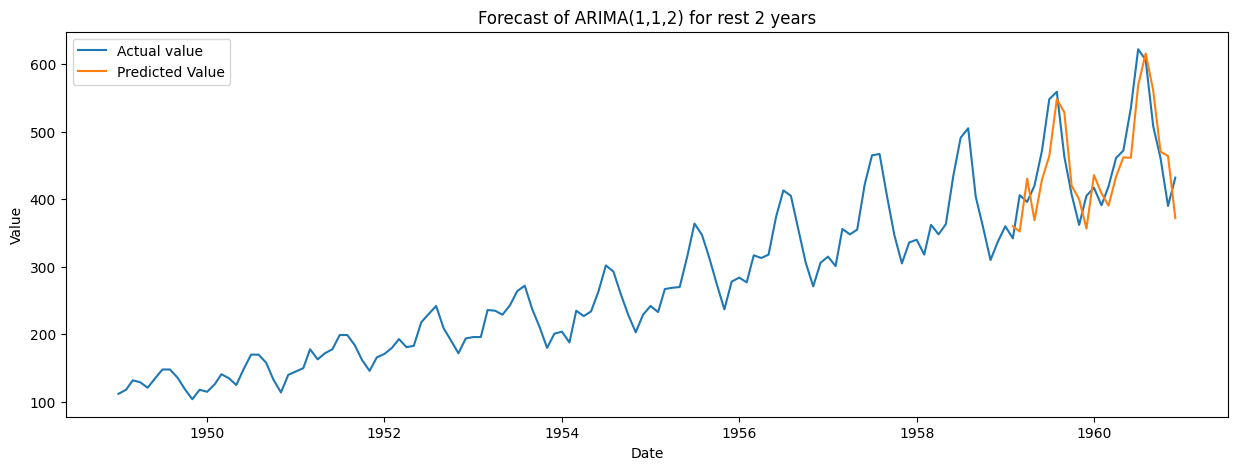

In [482]:
predictions_series = pd.Series(f1, index=test_set.index)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
plt.plot(spread, label='Actual value')
plt.plot(predictions_series, label='Predicted Value')
plt.title('Forecast of ARIMA(1,1,2) for rest 2 years')
plt.legend(loc="upper left")
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

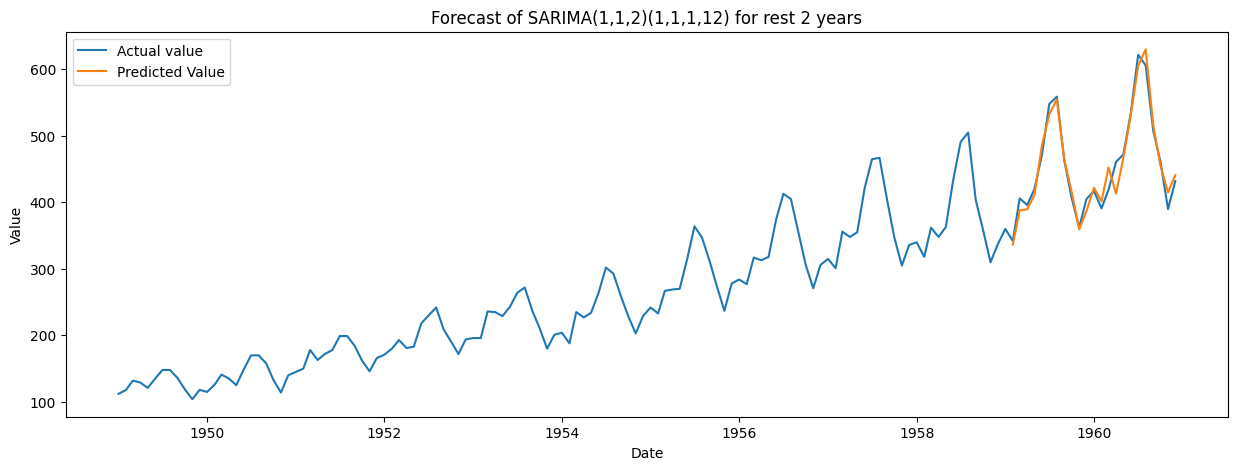

In [483]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


checker = spread.index <= '1959-01-01'

train_set = spread[checker]
test_set = spread[~checker]

n_train = len(train_set)
n_test = len(test_set)


f1, f1_error = [], []
ground_truth = []


for i in range(n_test):
    crt_time = i + n_train
    x_train = spread[:crt_time]

    #Let seasonality be 12
    model_1 = SARIMAX(x_train, order=(1, 1, 2), seasonal_order=(1, 1, 1, 12)).fit(disp=False)

    #predicted value
    forecast_1 = model_1.forecast(steps=1)

    # actual value
    y = spread[crt_time]


    ground_truth.append(y)
    f1.append(forecast_1[0])
    f1_error.append(y - forecast_1[0])


results = pd.DataFrame({
    'ground_truth': ground_truth,
    'forecast_1': f1,
    'forecast_1_error': f1_error
})


predictions_series = pd.Series(f1, index=test_set.index)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
plt.plot(spread, label='Actual value')
plt.plot(predictions_series, label='Predicted Value')
plt.title('Forecast of SARIMA(1,1,2)(1,1,1,12) for rest 2 years')
plt.legend(loc="upper left")
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

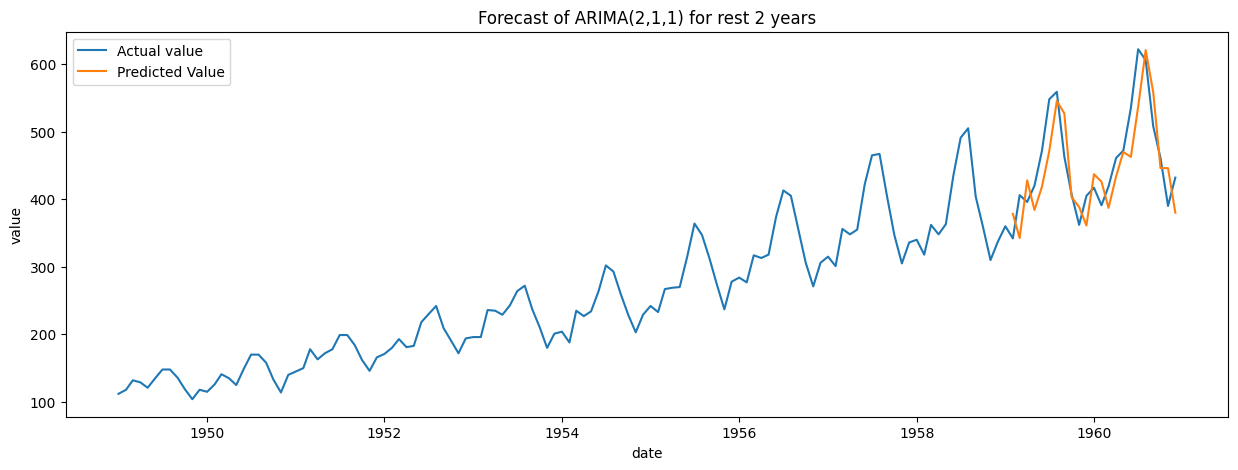

In [484]:
predictions_series = pd.Series(f2, index=test_set.index)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
plt.plot(spread, label='Actual value')
plt.plot(predictions_series, label='Predicted Value')
plt.legend(loc="upper left")
plt.title('Forecast of ARIMA(2,1,1) for rest 2 years')
plt.xlabel('date')
plt.ylabel('value')
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels

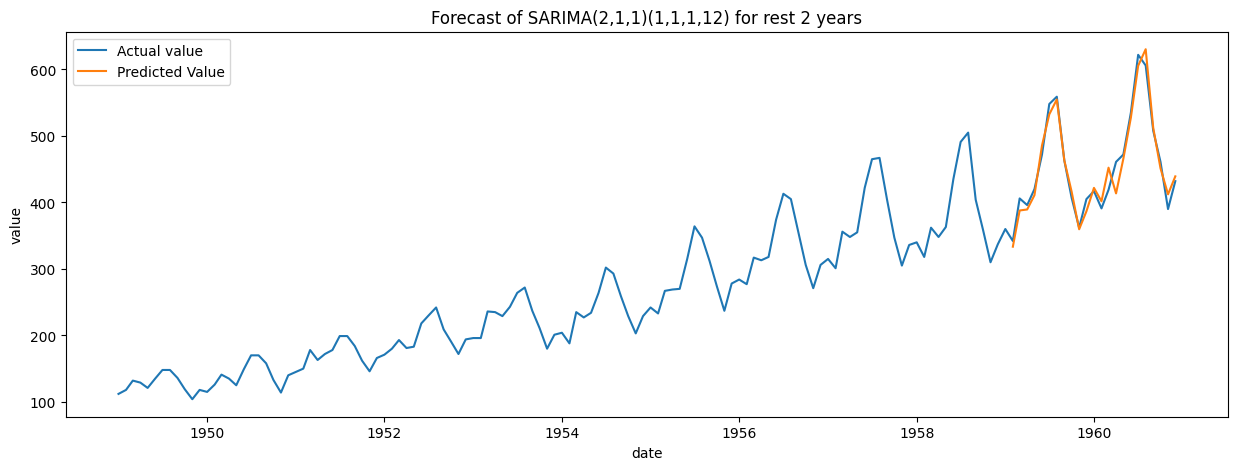

In [486]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


checker = spread.index <= '1959-01-01'

train_set = spread[checker]
test_set = spread[~checker]

n_train = len(train_set)
n_test = len(test_set)


f2, f2_error = [], []
ground_truth = []


for i in range(n_test):
    crt_time = i + n_train
    x_train = spread[:crt_time]


    model_2 = SARIMAX(x_train, order=(2, 1, 1), seasonal_order=(1, 1, 1, 12)).fit(disp=False)


    forecast_2 = model_2.forecast(steps=1)


    y = spread[crt_time]


    ground_truth.append(y)
    f2.append(forecast_2[0])
    f2_error.append(y - forecast_2[0])


results = pd.DataFrame({
    'ground_truth': ground_truth,
    'forecast_2': f2,
    'forecast_2_error': f2_error
})


predictions_series = pd.Series(f2, index=test_set.index)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
plt.plot(spread, label='Actual value')
plt.plot(predictions_series, label='Predicted Value')
plt.legend(loc="upper left")
plt.title('Forecast of SARIMA(2,1,1)(1,1,1,12) for rest 2 years')
plt.xlabel('date')
plt.ylabel('value')
plt.show()

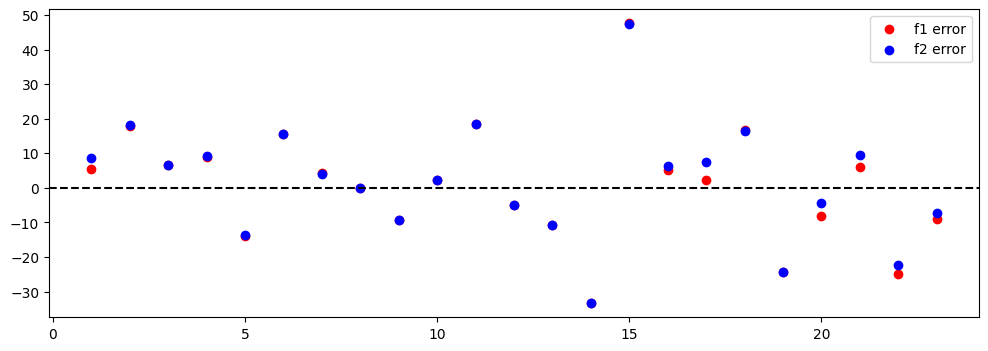

In [487]:
# plot the results
plt.figure(figsize=(12,4))
plt.scatter(np.linspace(1,len(f1_error),len(f1_error)), f1_error, label='f1 error', color='r')
plt.scatter(np.linspace(1,len(f2_error),len(f2_error)), f2_error, label='f2 error', color='b')
plt.axhline(y=0, color='k', linestyle='--')
plt.legend()
plt.show()

In [488]:
s_1959_02 = ground_truth[0]
f1_1959_02 = f1[0]
f2_1959_02 = f2[0]

f1 = pd.Series(f1)
f2 = pd.Series(f2)
f1_error = pd.Series(f1_error)
f2_error = pd.Series(f2_error)

print(f"Actual value:{s_1959_02}, f1 forecast:{f1_1959_02}, f2 forecast:{f2_1959_02}")
print(f"avg f1:{round(np.array(f1).mean(),4)}, avg f2:{round(np.array(f2).mean(),4)}")
print(f"var of f1:{round(np.array(f1).var(),4)}, var of f2:{round(np.array(f2).var(),4)}")
print(f'mean squared prediction error of f1: {round((f1_error**2).mean(),4)}, mean squared prediction error of f2: {round((f2_error**2).mean(),4)}')

Actual value:342, f1 forecast:336.49387677946066, f2 forecast:333.41680980774277
avg f1:455.4501, avg f2:454.5131
var of f1:5551.7343, var of f2:5548.3724
mean squared prediction error of f1: 285.8315, mean squared prediction error of f2: 283.1435


In [489]:
# Joint f-test for model 1
spread.reset_index(drop=True, inplace=True)
ground_truth=pd.Series(spread.iloc[120:].values.reshape(-1))


dta = pd.concat([pd.Series(f1,name='f1'), pd.Series(ground_truth,name='s')], axis=1)
dta.columns=['f1','s']
formula = 's ~ f1'
results = sm.OLS.from_formula(formula = formula, data = dta).fit()
hypotheses = '(Intercept = 0), (f1 = 1)'
f_test = results.f_test(hypotheses)
print(f_test)
print(results.params)

<F test: F=0.9958498330597886, p=0.3861946722519276, df_denom=21, df_num=2>
Intercept    83.807224
f1            0.810897
dtype: float64


In [490]:
# Joint f-test for model 2
dta = pd.concat([pd.Series(f2,name='f2'), pd.Series(ground_truth,name='s')], axis=1)
dta.columns=['f2','s']
formula = 's ~ f2'
results = sm.OLS.from_formula(formula = formula, data = dta).fit()
hypotheses = '(Intercept = 0), (f2 = 1)'
f_test = results.f_test(hypotheses)
print(f_test)
print(results.params)

<F test: F=0.9941994049582115, p=0.3867773248490442, df_denom=21, df_num=2>
Intercept    85.812398
f2            0.808157
dtype: float64


In [491]:
x_i = f1_error + f2_error
z_i = f1_error - f2_error
corr_xz = x_i.corr(z_i,method='pearson')
Granger_Newbold_stats = corr_xz/ np.sqrt( (1-corr_xz**2)/22 )
print(Granger_Newbold_stats)

0.46778828659720456


In [492]:
d = np.power(f1_error, 4) - np.power(f2_error, 4)
DM = np.mean(d) / np.power(np.var(d) / (len(d) - 1), 0.5)
print(DM)

acf_d = acf(d, nlags=12)[1:]
print(acf_d)

1.369073225479072
[-0.06503355 -0.02563459 -0.07283048 -0.04354843 -0.06238326 -0.07875037
  0.363522    0.04382262 -0.037982   -0.02878798 -0.04137851 -0.04935623]
